<a href="https://colab.research.google.com/github/Fsrkh/malaria-project/blob/main/Malaria_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

#Loading the Data

In [ ]:
dataset, dataset_info = tfds.load('malaria', split='train', with_info=True, as_supervised=False)

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

#Data pre-processing

In [ ]:
IMG_SIZE = 128

def preprocess(image, label):
    if tf.rank(image) == 2:
        image = tf.expand_dims(image, axis=-1)

    image.set_shape([None, None, image.shape[-1] if image.shape.ndims is not None else None])

    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label


dataset, dataset_info = tfds.load('malaria', split='train', with_info=True, as_supervised=True)

dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

BATCH_SIZE = 32
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

#Visualizing Dataset

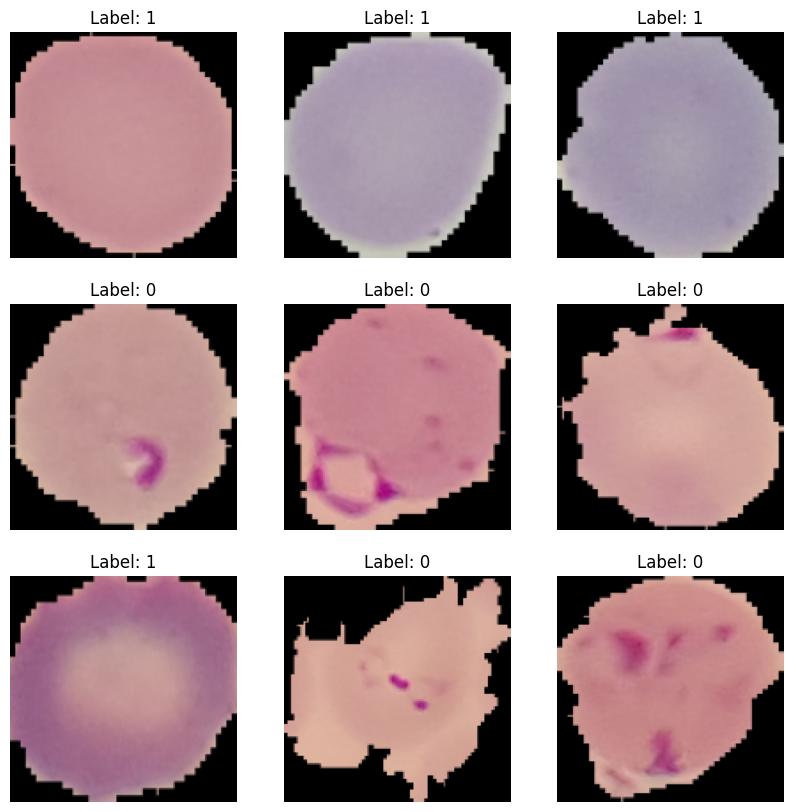

In [ ]:

for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        plt.title(f'Label: {label_batch[i].numpy()}')
        plt.axis('off')
    plt.show()


#Splitting The Data

In [ ]:
(train_dataset, val_dataset, test_dataset), dataset_info = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize the image
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

In [ ]:
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

#Building the model


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 15
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.7218 - loss: 0.5161 - val_accuracy: 0.9452 - val_loss: 0.1737
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.9450 - loss: 0.1697 - val_accuracy: 0.9499 - val_loss: 0.1557
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9585 - loss: 0.1242 - val_accuracy: 0.9448 - val_loss: 0.1565
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9615 - loss: 0.1113 - val_accuracy: 0.9441 - val_loss: 0.1585
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.9695 - loss: 0.0895 - val_accuracy: 0.9463 - val_loss: 0.1749
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.9753 - loss: 0.0708 - val_accuracy: 0.9452 - val_loss: 0.1933
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.9808 - loss: 0.0547 - val_accuracy: 0.9481 - val_loss: 0.2438
Epoch 8/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.9889 - loss: 0.0353 - 

#Model evaluation

In [ ]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9517 - loss: 0.4349


[0.4781993627548218, 0.9521045088768005]

In [ ]:
def parasite_or_not (x):
    if x > 0.5:
        return 'P'
    else:
        return 'U'

In [ ]:
parasite_or_not(model.predict(test_dataset.take(23))[0][0])

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


'P'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


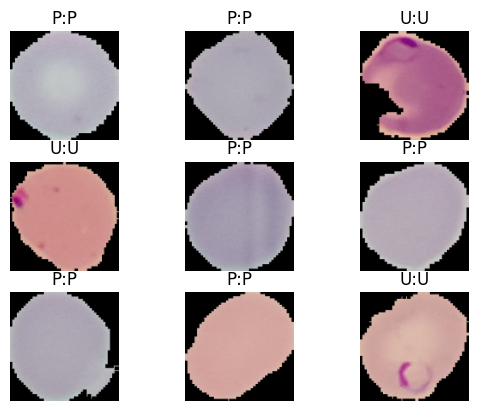

In [ ]:
for i , (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+':'+str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

#Saving and Loading From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
model.save('/content/drive/MyDrive/MyFolder/MalariaModel.h5')